Inception块

In [1]:
import torch
from torch import nn
from torch.nn  import functional as F
from d2l import torch as d2l

在GoogLeNet中，基本的卷积块被称为Inception块（Inception block）。这很可能得名于电影《盗梦空间》（Inception），因为电影中的一句话“我们需要走得更深”（“We need to go deeper”）。

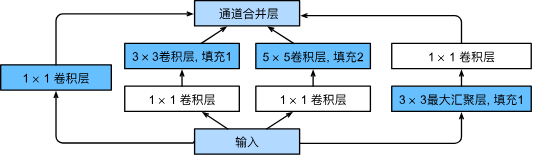

nception块由四条并行路径组成。 前三条路径使用窗口大小为1×1、3×3和5×5的卷积层，从不同空间大小中提取信息。 中间的两条路径在输入上执行1×1卷积，以减少通道数，从而降低模型的复杂性。 第四条路径使用3×3最大汇聚层，然后使用1×1卷积层来改变通道数。 这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。在Inception块中，通常调整的超参数是每层输出通道数。

In [26]:
class Inception(nn.Module):
    # c1-c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, *kwargs):
        super(Inception, self).__init__(*kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积后接3x3卷积
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积后接5x5卷积
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4 3x3最大汇聚层后接1x1卷积
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(
            self.p2_2(
                F.relu(self.p2_1(x))
            )
        )
        p3 = F.relu(
            self.p3_2(
                F.relu(
                    self.p3_1(x)
                )
            )-0
        )
        p4 = F.relu(
            self.p4_2(
                self.p4_1(x)
            )
        )
        # 在通道维度连接输出
        return torch.cat((p1, p2, p3, p4), dim=1)

这段代码定义了一个名为Inception的PyTorch模型类，它实现了Inception模块的结构。Inception模块是GoogleNet中提出的，它的主要特点是并行使用不同大小的卷积核和池化操作来捕获不同尺度的特征，然后将这些特征在通道维度上拼接起来。

下面是代码的详细解释：

导入模块：

torch：PyTorch的基础库。
nn：PyTorch中的神经网络模块。
functional：PyTorch中的函数式接口，通常用于在模型的前向传播中执行各种操作。
d2l：这可能是一个自定义库或者第三方库，用于深度学习相关的教学或研究。
定义Inception类：

继承自nn.Module，表示这是一个PyTorch模型。
初始化方法__init__接受以下参数：
in_channels：输入通道数。
c1, c2, c3, c4：分别代表四条路径的输出通道数。注意c2, c3是列表，因为它们的路径包含两个卷积层。
在初始化方法中，定义了四条路径的卷积和池化层：
线路1：一个1x1的卷积层。
线路2：首先是一个1x1的卷积层，然后是一个3x3的卷积层（带有padding=1以保持空间尺寸不变）。
线路3：首先是一个1x1的卷积层，然后是一个5x5的卷积层（带有padding=2以保持空间尺寸不变）。
线路4：首先是一个3x3的最大池化层（stride=1, padding=1，所以空间尺寸不变），然后是一个1x1的卷积层。
前向传播方法forward：

输入x首先通过四条路径进行卷积或池化操作。
每个路径的输出都经过ReLU激活函数。
最后，四条路径的输出在通道维度上通过torch.cat拼接起来。
这个Inception模块的设计允许模型同时考虑不同尺度的特征，这有助于模型更好地捕获图像中的复杂模式。在GoogleNet中，这种Inception模块被多次堆叠，以构建深度神经网络。


在Python的类继承中，super()函数用于调用父类（或超类）的一个方法。在PyTorch的nn.Module子类的定义中，super(Inception, self).__init__(**kwargs)这行代码的目的是调用nn.Module的初始化方法。

具体来说：

super(Inception, self)：这部分代码返回Inception类的父类（即nn.Module）的一个临时对象，这样你就可以调用父类的方法。在Python 3中，更常见的写法是super().__init__(**kwargs)，因为Python 3的super()可以自动推断出类名和self参数。
.__init__(**kwargs)：这是nn.Module的初始化方法。通过调用它，你确保了Inception类继承自nn.Module的所有基本设置都被正确初始化。
**kwargs：这是一个字典解包操作，它会把所有传递给Inception类的关键字参数传递给nn.Module的初始化方法。这样做的好处是，如果nn.Module的初始化方法在未来版本中有新的关键字参数，那么Inception类可以不需要修改就能兼容这些新参数。
简而言之，这行代码的作用是调用nn.Module的初始化方法，以确保Inception类具有一个正确初始化的nn.Module对象作为基类。这是PyTorch中定义自定义神经网络模块时的标准做法。


GoogLeNet一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。Inception块之间的最大汇聚层可降低维度。 第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。

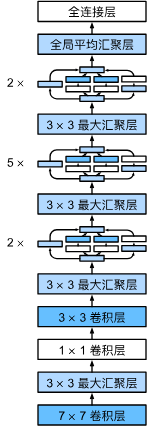

逐步实现GoogleNet的每个模块
第一个模块使用64个通道，7x7卷积

In [27]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

第二个模块使用两个卷积层：第一个卷积层是64个通道、1×1卷积层；第二个卷积层使用将通道数量增加三倍的3×3卷积层。 这对应于Inception块中的第二条路径。

In [28]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

第三个模块串联两个完整的Inception块。 第一个Inception块的输出通道数为64+128+32+32=256，四个路径之间的输出通道数量比为64:128:32:32=2:4:1:1。 第二个和第三个路径首先将输入通道的数量分别减少到96/192=1/2和16/192=1/12，然后连接第二个卷积层。第二个Inception块的输出通道数增加到128+192+96+64=480，四个路径之间的输出通道数量比为128:192:96:64=4:6:3:2。 第二条和第三条路径首先将输入通道的数量分别减少到128/256=1/2和32/256=1/8。


In [29]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

第四模块更加复杂， 它串联了5个Inception块，其输出通道数分别是192+208+48+64=512、160+224+64+64=512、128+256+64+64=512、112+288+64+64=528和256+320+128+128=832。 这些路径的通道数分配和第三模块中的类似，首先是含3×3卷积层的第二条路径输出最多通道，其次是仅含1×1卷积层的第一条路径，之后是含5×5卷积层的第三条路径和含3×3最大汇聚层的第四条路径。 其中第二、第三条路径都会先按比例减小通道数。 这些比例在各个Inception块中都略有不同。

In [38]:
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (114, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

第五模块包含输出通道数为256+320+128+128=832和384+384+128+128=1024的两个Inception块。 其中每条路径通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。 需要注意的是，第五模块的后面紧跟输出层，该模块同NiN一样使用全局平均汇聚层，将每个通道的高和宽变成1。 最后我们将输出变成二维数组，再接上一个输出个数为标签类别数的全连接层。

In [39]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)

In [40]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

GoogLeNet模型的计算复杂，而且不如VGG那样便于修改通道数。 为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96，这简化了计算。下面演示各个模块输出的形状变化。

In [41]:
X = torch.rand(size=(1,1,96,96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output \t:', X.shape)

Sequential output 	: torch.Size([1, 64, 24, 24])
Sequential output 	: torch.Size([1, 192, 12, 12])
Sequential output 	: torch.Size([1, 480, 6, 6])
Sequential output 	: torch.Size([1, 832, 3, 3])
Sequential output 	: torch.Size([1, 1024])
Linear output 	: torch.Size([1, 10])


训练模型

我们使用Fashion-MNIST数据集来训练我们的模型。在训练之前，我们将图片转换为96×96分辨率

In [43]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

loss 0.247, train acc 0.906, test acc 0.901
3138.6 examples/sec on cuda:0


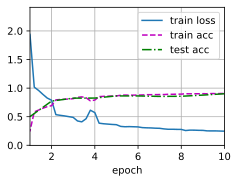

In [44]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())